# Natural language to SQL

**Run in [Google Colab](https://colab.research.google.com/) For GPU.**

This model have  Mistral as a base and it has been fine-tuned to excel in SQL code generation.

In [ ]:
from google.colab import userdata
userdata.get("HF_TOKEN")

In [2]:
#Install the lastest versions of peft & transformers library recommended
#if you want to work with the most recent models
!pip install -q git+https://github.com/huggingface/peft.git
!pip install git+https://github.com/huggingface/accelerate.git
!pip install git+https://github.com/huggingface/transformers.git
!pip install bitsandbytes

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/huggingface/accelerate.git to /tmp/pip-req-build-i6zo5e79
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/accelerate.git /tmp/pip-req-build-i6zo5e79
  Resolved https://github.com/huggingface/accelerate.git to commit 682691deaca2637e0a2efeaa5ebb6dd8bade8c30
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/huggingface/transformers.git to /tmp/pip-req-build-sblfq6a_
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers.git /tmp/pip-req-build-sblfq6a_
  Resolved https://github.com/huggingface/transformers.git to commit 02f946a0386c67540538030da2ff87bbac5eca24
  Installing build dependencies ... done
  Getting requirements to build whe

In [3]:
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
import torch
import accelerate

In [4]:
model_name = "defog/sqlcoder-7b"

We need to create the Quantization configuration to load the Model.

It is a large model and I want it to fit in a 16GB GPU, I'm going to use a 4 bits quantization.

If you want to learn more about quantization, refer to this article: [QLoRA: Training a Large Language Model on a 16GB GPU.](https://medium.com/towards-artificial-intelligence/qlora-training-a-large-language-model-on-a-16gb-gpu-00ea965667c1)

You can try to use this model in a 8 bit quantizations and check in you see any improvements in the results.

In [5]:
bnb_config = BitsAndBytesConfig(
  load_in_4bit=True,
  bnb_4bit_use_double_quant=True,
  bnb_4bit_quant_type="nf4",
  bnb_4bit_compute_dtype=torch.bfloat16
)


To load the model I pass to the AutoModelForCasualLM teh quantization configurations, and HuggingFace take care of all the hard work.

In [6]:
foundation_model = AutoModelForCausalLM.from_pretrained(model_name,
                    quantization_config=bnb_config,
                    device_map='auto',
                    use_cache = True)

config.json:   0%|          | 0.00/619 [00:00<?, ?B/s]

pytorch_model.bin.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

pytorch_model-00002-of-00002.bin:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

pytorch_model-00001-of-00002.bin:   0%|          | 0.00/9.94G [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/25.1k [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

In [7]:
tokenizer = AutoTokenizer.from_pretrained(model_name)
eos_token_id = tokenizer.convert_tokens_to_ids(["```"])[0]

tokenizer_config.json:   0%|          | 0.00/915 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/72.0 [00:00<?, ?B/s]

This function wraps the call to *model.generate*

In [8]:
#this function returns the outputs from the model received, and inputs.
def get_outputs(model, inputs, max_new_tokens=400):
    outputs = model.generate(
        input_ids=inputs["input_ids"],
        attention_mask=inputs["attention_mask"],
        num_return_sequences=1,
        eos_token_id=eos_token_id,
        pad_token_id=eos_token_id,
        max_new_tokens=max_new_tokens,
        do_sample=False,
        num_beams=5
    )
    return outputs

# Prompt without Shots.
In this first PROMPT we are going to give Instructions to the model and pass the structure of the Database.

The instructions are significantly different from those we are passing to GPT-3.5-Turbo. This model is really well fine-tuned, but it is smaller than GPT-3.5.

We need to be more clear with the instructions, as it does not have the same capacity to understand our orders as GPT-3.5.

In [43]:
sp_nl2sql = """
    ### Instructions:
Your task is convert a question into a SQL query, given a SQL database schema.
Adhere to these rules:
- **Deliberately go through the question and database schema word by word** to appropriately answer the question

    ### Input
    Generate a SQL query that answers the question below.
    This query will run on a database whose schema is represented in this string:

    CREATE 3+ TABLES HERE

    ### Response
    Based on your instructions, here is the SQL query I have generated to answer the question
    `{question}`:
    ```sql3

    """

In [44]:
sp_nl2sql = sp_nl2sql.format(question="List the names of all employees in the sales department hired after 2020.")
print(sp_nl2sql)


    ### Instructions:
Your task is convert a question into a SQL query, given a SQL database schema.
Adhere to these rules:
- **Deliberately go through the question and database schema word by word** to appropriately answer the question

    ### Input
    Generate a SQL query that answers the question below.
    This query will run on a database whose schema is represented in this string:

    CREATE 3+ TABLES HERE

    ### Response
    Based on your instructions, here is the SQL query I have generated to answer the question
    `List the names of all employees in the sales department hired after 2020.`:
    ```sql3
    
    


In [45]:
input_sentences = tokenizer(sp_nl2sql, return_tensors="pt").to('cuda')
response = get_outputs(foundation_model, input_sentences, max_new_tokens=400)
SQL = tokenizer.batch_decode(response, skip_special_tokens=True)

In [46]:
#Empty the cache in orde to do more calls without problems.
torch.cuda.empty_cache()

In [47]:
print(SQL[0].split("```sql3")[-1].split("```")[0].split(";")[0].strip() + ";")

SELECT first_name, last_name FROM employees WHERE department_name ILIKE '%sales%' AND hire_date > '2020-01-01';


#### Test with a schema and the same query

In [14]:
sp_nl2sql = """
    ### Instructions:
Your task is convert a question into a SQL query, given a SQL database schema.
Adhere to these rules:
- **Deliberately go through the question and database schema word by word** to appropriately answer the question

    ### Input
    Generate a SQL query that answers the question below.
    This query will run on a database whose schema is represented in this string:

    CREATE TABLE employees (
      employee_id INT PRIMARY KEY,
      first_name TEXT,
      last_name TEXT,
      department_id INT,
      hire_date DATE
    );

    CREATE TABLE departments (
        department_id INT PRIMARY KEY,
        department_name TEXT
    );

    CREATE TABLE salaries (
        employee_id INT,
        salary NUMERIC,
        effective_date DATE
    );

    CREATE TABLE projects (
        project_id INT PRIMARY KEY,
        project_name TEXT,
        start_date DATE,
        end_date DATE
    );


    ### Response
    Based on your instructions, here is the SQL query I have generated to answer the question
    `{question}`:
    ```sql3
    """

In [15]:
sp_nl2sql = sp_nl2sql.format(question="List the names of all employees in the sales department hired after 2020.")
print(sp_nl2sql)


    ### Instructions:
Your task is convert a question into a SQL query, given a SQL database schema.
Adhere to these rules:
- **Deliberately go through the question and database schema word by word** to appropriately answer the question

    ### Input
    Generate a SQL query that answers the question below.
    This query will run on a database whose schema is represented in this string:

    CREATE TABLE employees (
      employee_id INT PRIMARY KEY,
      first_name TEXT,
      last_name TEXT,
      department_id INT,
      hire_date DATE
    );

    CREATE TABLE departments (
        department_id INT PRIMARY KEY,
        department_name TEXT
    );

    CREATE TABLE salaries (
        employee_id INT,
        salary NUMERIC,
        effective_date DATE
    );

    CREATE TABLE projects (
        project_id INT PRIMARY KEY,
        project_name TEXT,
        start_date DATE,
        end_date DATE
    );


    ### Response
    Based on your instructions, here is the SQL query I hav

In [16]:
input_sentences = tokenizer(sp_nl2sql, return_tensors="pt").to('cuda')
response = get_outputs(foundation_model, input_sentences, max_new_tokens=400)
SQL = tokenizer.batch_decode(response, skip_special_tokens=True)

In [17]:
#Empty the cache in orde to do more calls without problems.
torch.cuda.empty_cache()

In [18]:
print(SQL[0].split("```sql3")[-1].split("```")[0].split(";")[0].strip() + ";")

SELECT employees.first_name, employees.last_name FROM employees JOIN salaries ON employees.employee_id = salaries.employee_id JOIN departments ON employees.department_id = departments.department_id WHERE departments.department_name ilike '%sales%' AND salaries.effective_date > '2020-01-01' ORDER BY employees.last_name, employees.first_name NULLS LAST;


### Key Insight
Providing the schema drastically improved the model’s output quality and alignment with relational structure.

Without a schema, the model still performs impressively, but results may require manual adaptation to fit a specific database.

#Prompt with shots OpenAI Style.
In this second prompt we are going to add some Shots with samples to see if our SQL style affects the model.

In [32]:
sp_nl2sql2 = """
  ### Instructions:
  Your task is to convert a question into a SQL query, given a SQL database schema.
  Adhere to these rules:
  - Deliberately go through the question and database schema word by word to appropriately answer the question
  - Use the sample SQL queries in the ### Samples section to learn more about the database structure and style

  ### Input
  This query will run on a database whose schema is represented in this string:

  CREATE TABLE employees (
      employee_id INT PRIMARY KEY,
      first_name TEXT,
      last_name TEXT,
      department_id INT,
      hire_date DATE
  );

  CREATE TABLE departments (
      department_id INT PRIMARY KEY,
      department_name TEXT
  );

  CREATE TABLE salaries (
      employee_id INT,
      salary NUMERIC,
      effective_date DATE
  );

  CREATE TABLE projects (
      project_id INT PRIMARY KEY,
      project_name TEXT,
      start_date DATE,
      end_date DATE
  );

  ### Samples

  `List the names of all employees in the marketing department`:
  ```sql
  SELECT e.first_name, e.last_name
  FROM employees e
  JOIN departments d ON e.department_id = d.department_id
  WHERE d.department_name ILIKE '%marketing%';
  ```

  `List all employees hired after 2021`:
  ```sql
  SELECT first_name, last_name
  FROM employees
  WHERE hire_date > '2021-01-01';
  ```

  `Return the names and salaries of employees earning more than 60000`:
  ```sql
  SELECT e.first_name, e.last_name, s.salary
  FROM employees e
  JOIN salaries s ON e.employee_id = s.employee_id
  WHERE s.salary > 60000;
  ```

  ### Responses
  Write only the SQL query below. Do not repeat the input or headers.

  `{question}`:
  ```sql

  """


In [33]:
sp_nl2sql2 = sp_nl2sql2.format(question="Return The name of the best paid employee")
(print(sp_nl2sql2))


  ### Instructions:
  Your task is to convert a question into a SQL query, given a SQL database schema.
  Adhere to these rules:
  - Deliberately go through the question and database schema word by word to appropriately answer the question
  - Use the sample SQL queries in the ### Samples section to learn more about the database structure and style

  ### Input
  This query will run on a database whose schema is represented in this string:

  CREATE TABLE employees (
      employee_id INT PRIMARY KEY,
      first_name TEXT,
      last_name TEXT,
      department_id INT,
      hire_date DATE
  );

  CREATE TABLE departments (
      department_id INT PRIMARY KEY,
      department_name TEXT
  );

  CREATE TABLE salaries (
      employee_id INT,
      salary NUMERIC,
      effective_date DATE
  );

  CREATE TABLE projects (
      project_id INT PRIMARY KEY,
      project_name TEXT,
      start_date DATE,
      end_date DATE
  );

  ### Samples

  `List the names of all employees in the ma

In [34]:
input_sentences = tokenizer(sp_nl2sql2, return_tensors="pt").to('cuda')
response = get_outputs(foundation_model, input_sentences, max_new_tokens=400)
SQL = tokenizer.batch_decode(response, skip_special_tokens=True)
torch.cuda.empty_cache()

In [35]:
print(SQL[0].split("```sql3")[-1].split("```")[0].split(";")[0].strip() + ";")

### Instructions:
  Your task is to convert a question into a SQL query, given a SQL database schema.
  Adhere to these rules:
  - Deliberately go through the question and database schema word by word to appropriately answer the question
  - Use the sample SQL queries in the ### Samples section to learn more about the database structure and style

  ### Input
  This query will run on a database whose schema is represented in this string:

  CREATE TABLE employees (
      employee_id INT PRIMARY KEY,
      first_name TEXT,
      last_name TEXT,
      department_id INT,
      hire_date DATE
  );


The Order is really different from the one obtained with the first prompt.

The first difference is the format. But The SQL is realy more simple, at least it is my sensation.

#Prompt with Shots in Sample Style.

In this prompt, we will place the examples in a separate section, and in the instructions, we will instruct the model to pay attention to them in order to generate the SQL commands.

In [36]:
sp_nl2sql3b = """
    ### Instructions:
Your task is convert a question into a SQL query, given a SQL database schema.
Adhere to these rules:
- **Deliberately go through the question and database schema word by word** to appropriately answer the question
- **Use the samples SQL In the ### Samples section to learn more about the Databases structure


    ### Input
    Generate a SQL query that answers the question below.
    This query will run on a database whose schema is represented in this string:

    CREATE TABLE employees (
      employee_id INT PRIMARY KEY,
      first_name TEXT,
      last_name TEXT,
      department_id INT,
      hire_date DATE
    );

    CREATE TABLE departments (
      department_id INT PRIMARY KEY,
      department_name TEXT
    );

    CREATE TABLE salaries (
      employee_id INT,
      salary NUMERIC,
      effective_date DATE
    );

    CREATE TABLE projects (
      project_id INT PRIMARY KEY,
      project_name TEXT,
      start_date DATE,
      end_date DATE
    );

    ### Samples

    `List the names of all employees in the marketing department`:
    ```sql
    SELECT e.first_name, e.last_name
    FROM employees e
    JOIN departments d ON e.department_id = d.department_id
    WHERE d.department_name ILIKE '%marketing%';
    ```

    `List all employees hired after 2021`:
    ```sql
    SELECT first_name, last_name
    FROM employees
    WHERE hire_date > '2021-01-01';
    ```

    `Return the names and salaries of employees earning more than 60000`:
    ```sql
    SELECT e.first_name, e.last_name, s.salary
    FROM employees e
    JOIN salaries s ON e.employee_id = s.employee_id
    WHERE s.salary > 60000;

    ### Response
    Based on your instructions, here is the SQL query I have generated to answer the question
    `{question}`:
    ```sql3
    """


In [37]:
sp_nl2sql3 = sp_nl2sql3b.format(question="Return The name of the best paid employee")
print (sp_nl2sql3)


    ### Instructions:
Your task is convert a question into a SQL query, given a SQL database schema.
Adhere to these rules:
- **Deliberately go through the question and database schema word by word** to appropriately answer the question
- **Use the samples SQL In the ### Samples section to learn more about the Databases structure


    ### Input
    Generate a SQL query that answers the question below.
    This query will run on a database whose schema is represented in this string:

    CREATE TABLE employees (
      employee_id INT PRIMARY KEY,
      first_name TEXT,
      last_name TEXT,
      department_id INT,
      hire_date DATE
    );

    CREATE TABLE departments (
      department_id INT PRIMARY KEY,
      department_name TEXT
    );

    CREATE TABLE salaries (
      employee_id INT,
      salary NUMERIC,
      effective_date DATE
    );

    CREATE TABLE projects (
      project_id INT PRIMARY KEY,
      project_name TEXT,
      start_date DATE,
      end_date DATE
    );


In [38]:
input_sentences = tokenizer(sp_nl2sql3, return_tensors="pt").to('cuda')
response = get_outputs(foundation_model, input_sentences, max_new_tokens=400)
SQL = tokenizer.batch_decode(response, skip_special_tokens=True)
torch.cuda.empty_cache()

In [39]:
print(SQL[0].split("```sql3")[-1].split("```")[0].split(";")[0].strip() + ";")

SELECT first_name, last_name
    FROM employees e
    JOIN salaries s ON e.employee_id = s.employee_id
    WHERE s.salary = (SELECT MAX(salary) FROM salaries);


#Now the question in spanish.


In [40]:
sp_nl2sql3 = sp_nl2sql3b.format(question="Devolver El nombre del empleado mejor pagado")
print (sp_nl2sql3)


    ### Instructions:
Your task is convert a question into a SQL query, given a SQL database schema.
Adhere to these rules:
- **Deliberately go through the question and database schema word by word** to appropriately answer the question
- **Use the samples SQL In the ### Samples section to learn more about the Databases structure


    ### Input
    Generate a SQL query that answers the question below.
    This query will run on a database whose schema is represented in this string:

    CREATE TABLE employees (
      employee_id INT PRIMARY KEY,
      first_name TEXT,
      last_name TEXT,
      department_id INT,
      hire_date DATE
    );

    CREATE TABLE departments (
      department_id INT PRIMARY KEY,
      department_name TEXT
    );

    CREATE TABLE salaries (
      employee_id INT,
      salary NUMERIC,
      effective_date DATE
    );

    CREATE TABLE projects (
      project_id INT PRIMARY KEY,
      project_name TEXT,
      start_date DATE,
      end_date DATE
    );


In [41]:
input_sentences = tokenizer(sp_nl2sql3, return_tensors="pt").to('cuda')
response = get_outputs(foundation_model, input_sentences, max_new_tokens=400)
SQL = tokenizer.batch_decode(response, skip_special_tokens=True)
torch.cuda.empty_cache()

In [42]:
print(SQL[0].split("```sql3")[-1].split("```")[0].split(";")[0].strip() + ";")

SELECT e.first_name, e.last_name, MAX(s.salary) AS max_salary
    FROM employees e
    JOIN salaries s ON e.employee_id = s.employee_id
    GROUP BY e.first_name, e.last_name
    ORDER BY max_salary DESC NULLS LAST;


The generated SQL command is the same regardless of where we have placed the examples.

#Conclusions.

Let's see the three SQL's together.

* SELECT employees.name, MAX(salary.salary) AS max_salary FROM employees JOIN salary ON employees.ID_Usr = salary.ID_Usr GROUP BY employees.name ORDER BY max_salary DESC NULLS LAST LIMIT 1;

* SELECT e.name
    FROM employees e
    JOIN salary s ON e.ID_Usr = s.ID_usr
    WHERE s.salary = (SELECT MAX(salary) FROM salary);

* SELECT e.name
    FROM employees e
    JOIN salary s ON e.ID_Usr = s.ID_usr
    WHERE s.salary = (SELECT MAX(salary) FROM salary);

* Spanish Question: SELECT e.name
     FROM employees e
     JOIN salary s ON e.ID_Usr = s.ID_Usr
     WHERE s.salary = (SELECT MAX(salary) FROM salary)
     GROUP BY e.name
     ORDER BY COUNT(studies.ID_study) DESC
     LIMIT 1;


**The model has demonstrated that it is highly efficient in crafting SQL.** Additionally, it pays a lot of attention, perhaps too much, to the examples we provide. Clearly, these examples should be crafted by one of the best SQL programmers we have access to, though their use may not be essential.

On the other hand, although the model is clearly very proficient in SQL generation, during the creation of the notebook, I have encountered several issues because the commands need to be extremely clear. It doesn't handle typos well (which should not exist).

It appears to have some issues when it receives commands in Spanish. I assume this problem would be present in any language other than English. Therefore, since it's a tool that could be used by non-technical personnel, this should be considered in environments where English is not the primary language.

# Exercise
 - Complete the prompts similar to what we did in class.
     - Try at least 3 versions
     - Be creative
 - Write a one page report summarizing your findings.
     - Were there variations that didn't work well? i.e., where GPT either hallucinated or wrong
 - What did you learn?

### Changing the shape of the sample for user visibility

In [48]:
sp_nl2sql3b = """
### Instructions:
Your task is to convert a question into a SQL query, based on the example data tables.
Adhere to these rules:
- Deliberately go through the question and table examples row by row to appropriately infer the meaning
- Use the data examples in the ### Samples section to understand the database structure and relationships

### Input
The query you generate will run on a database similar to the tables below:

### Table: employees

| employee_id | first_name | last_name | department_id | hire_date   |
|-------------|------------|-----------|----------------|-------------|
| 1           | Alice      | Smith     | 10             | 2021-03-12  |
| 2           | Bob        | Taylor    | 20             | 2022-07-19  |
| 3           | Clara      | Lopez     | 10             | 2020-11-01  |

### Table: departments

| department_id | department_name |
|---------------|-----------------|
| 10            | Sales           |
| 20            | Marketing       |

### Table: salaries

| employee_id | salary  | effective_date |
|-------------|---------|----------------|
| 1           | 60000   | 2022-01-01     |
| 2           | 75000   | 2023-01-01     |
| 3           | 58000   | 2021-05-01     |

### Table: projects

| project_id | project_name       | start_date | end_date   |
|------------|--------------------|------------|------------|
| 101        | CRM Migration      | 2022-03-01 | 2022-08-15 |
| 102        | Website Redesign   | 2023-01-10 | 2023-04-30 |

### Response
Based on your instructions, here is the SQL query I have generated to answer the question:
`{question}`:
```sql3

"""


In [49]:
sp_nl2sql3 = sp_nl2sql3b.format(question="Return The name of the best paid employee")
print (sp_nl2sql3)


### Instructions:
Your task is to convert a question into a SQL query, based on the example data tables.
Adhere to these rules:
- Deliberately go through the question and table examples row by row to appropriately infer the meaning
- Use the data examples in the ### Samples section to understand the database structure and relationships

### Input
The query you generate will run on a database similar to the tables below:

### Table: employees

| employee_id | first_name | last_name | department_id | hire_date   |
|-------------|------------|-----------|----------------|-------------|
| 1           | Alice      | Smith     | 10             | 2021-03-12  |
| 2           | Bob        | Taylor    | 20             | 2022-07-19  |
| 3           | Clara      | Lopez     | 10             | 2020-11-01  |

### Table: departments

| department_id | department_name |
|---------------|-----------------|
| 10            | Sales           |
| 20            | Marketing       |

### Table: salaries

| 

In [50]:
input_sentences = tokenizer(sp_nl2sql3, return_tensors="pt").to('cuda')
response = get_outputs(foundation_model, input_sentences, max_new_tokens=400)
SQL = tokenizer.batch_decode(response, skip_special_tokens=True)
torch.cuda.empty_cache()

In [51]:
print(SQL[0].split("```sql3")[-1].split("```")[0].split(";")[0].strip() + ";")

SELECT first_name, last_name FROM salaries AS s JOIN employees AS e ON s.employee_id = e.employee_id ORDER BY s.salary DESC NULLS LAST LIMIT 1;


### New request

In [52]:
sp_nl2sql3 = sp_nl2sql3b.format(question="Return The employees in marketing hired after 2021")
print (sp_nl2sql3)


### Instructions:
Your task is to convert a question into a SQL query, based on the example data tables.
Adhere to these rules:
- Deliberately go through the question and table examples row by row to appropriately infer the meaning
- Use the data examples in the ### Samples section to understand the database structure and relationships

### Input
The query you generate will run on a database similar to the tables below:

### Table: employees

| employee_id | first_name | last_name | department_id | hire_date   |
|-------------|------------|-----------|----------------|-------------|
| 1           | Alice      | Smith     | 10             | 2021-03-12  |
| 2           | Bob        | Taylor    | 20             | 2022-07-19  |
| 3           | Clara      | Lopez     | 10             | 2020-11-01  |

### Table: departments

| department_id | department_name |
|---------------|-----------------|
| 10            | Sales           |
| 20            | Marketing       |

### Table: salaries

| 

In [53]:
input_sentences = tokenizer(sp_nl2sql3, return_tensors="pt").to('cuda')
response = get_outputs(foundation_model, input_sentences, max_new_tokens=400)
SQL = tokenizer.batch_decode(response, skip_special_tokens=True)
torch.cuda.empty_cache()

In [54]:
print(SQL[0].split("```sql3")[-1].split("```")[0].split(";")[0].strip() + ";")

SELECT a.first_name, a.last_name FROM employees a JOIN departments b ON a.department_id = b.department_;


### A project-based query (to test projects table)

In [57]:
sp_nl2sql = sp_nl2sql3b.format(question="List the names of all projects that ended before 2023")
print (sp_nl2sql)


### Instructions:
Your task is to convert a question into a SQL query, based on the example data tables.
Adhere to these rules:
- Deliberately go through the question and table examples row by row to appropriately infer the meaning
- Use the data examples in the ### Samples section to understand the database structure and relationships

### Input
The query you generate will run on a database similar to the tables below:

### Table: employees

| employee_id | first_name | last_name | department_id | hire_date   |
|-------------|------------|-----------|----------------|-------------|
| 1           | Alice      | Smith     | 10             | 2021-03-12  |
| 2           | Bob        | Taylor    | 20             | 2022-07-19  |
| 3           | Clara      | Lopez     | 10             | 2020-11-01  |

### Table: departments

| department_id | department_name |
|---------------|-----------------|
| 10            | Sales           |
| 20            | Marketing       |

### Table: salaries

| 

In [58]:
input_sentences = tokenizer(sp_nl2sql3, return_tensors="pt").to('cuda')
response = get_outputs(foundation_model, input_sentences, max_new_tokens=400)
SQL = tokenizer.batch_decode(response, skip_special_tokens=True)
torch.cuda.empty_cache()

In [59]:
print(SQL[0].split("```sql3")[-1].split("```")[0].split(";")[0].strip() + ";")

SELECT a.first_name, a.last_name FROM employees a JOIN departments b ON a.department_id = b.department_;


## Observations
### Key Insights
Table-Based Prompting Works Very Well
Providing inline table data (with realistic rows) helps the model infer relationships and semantics more naturally — even without sample SQL. It mimics the way humans reason about relational logic.

Query Accuracy Improves With Realistic Context
Compared to schema-only prompts, the model shows better structural accuracy when fed actual table data, thanks to its ability to ground column meanings in real row values.

Instructions Matter
Clear segmenting between Instructions, Input, and Response makes a difference. Ending with an isolated {question} and sql block helps force a clean output.

### Output comparison
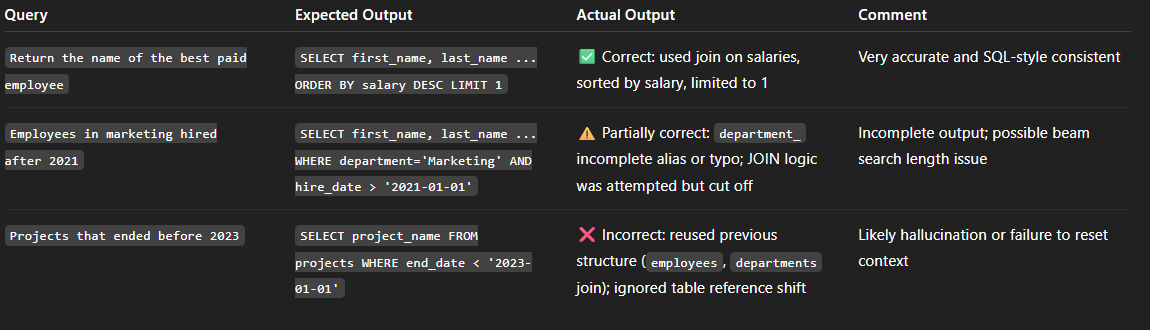

### Lesson learned
- Table-based samples improve generalization and model understanding when schema definitions are absent.
- The model remains prone to minor errors like:
  - Truncated identifiers (department_)
  - Reused structure across unrelated prompts (copy/paste style hallucinations)
- Execution time (~5min) is a tradeoff of running large quantized models like defog/sqlcoder-7b with beam search and high max_new_tokens.

###Final Takeaway
Providing a realistic data snapshot via table-shaped examples significantly enhances output quality.

However, occasional model drift or beam cutoff errors remind us to validate and test outputs — even from strong LLMs.